In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd

/home/as111/sipm-analysis


## Example waveforms

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies//2022-11-22/2022-11-22_volt_65_pos_bottom_light_laser_coinc_laser_cond_calibration/0/wave0.dat


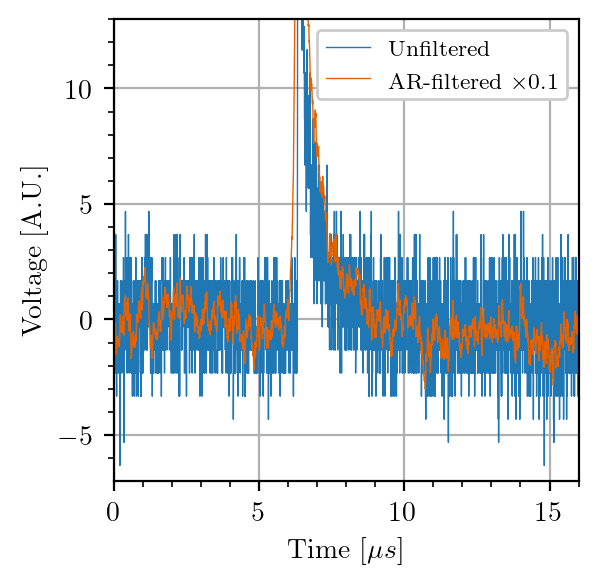

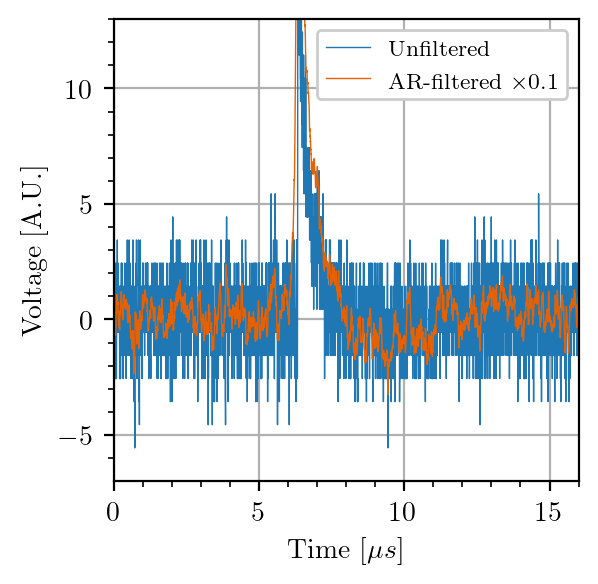

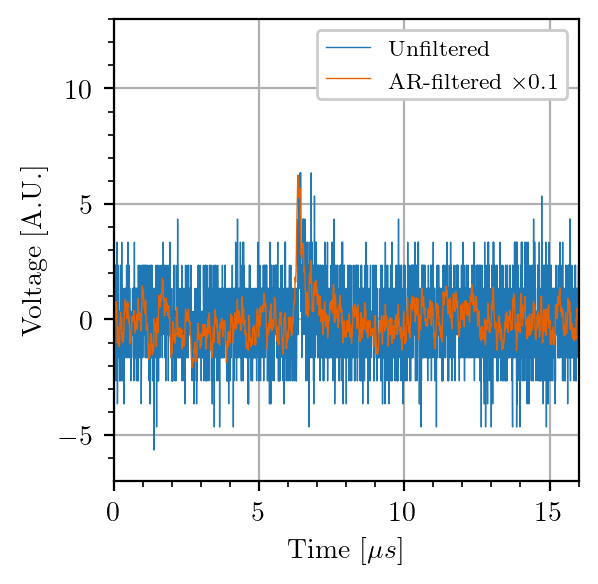

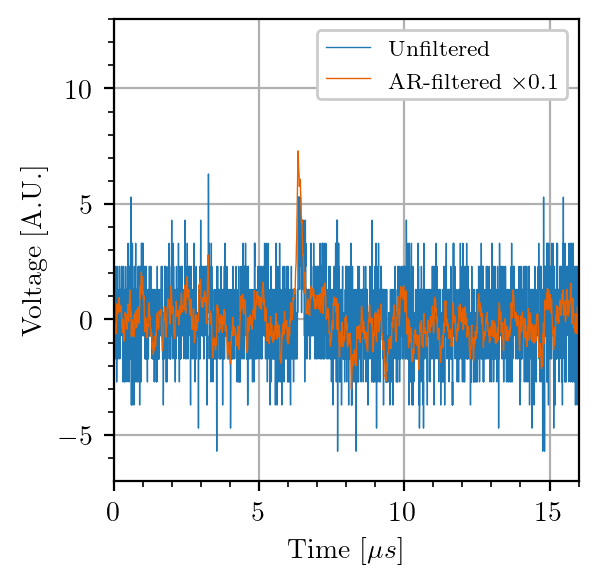

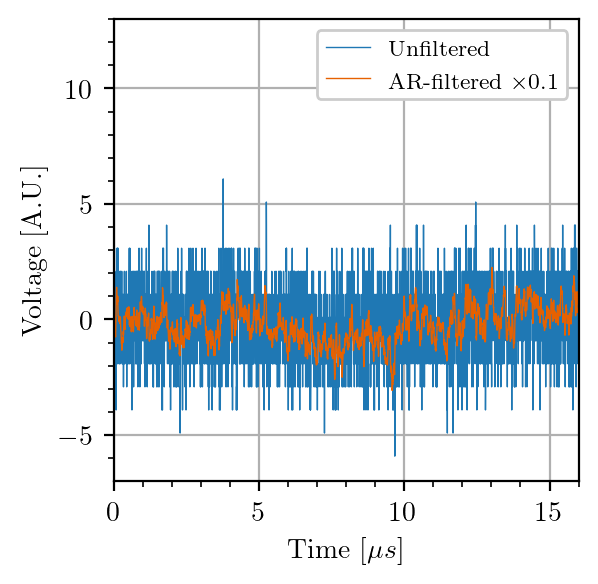

In [4]:
import sipm.recon.WaveformDataset as wfd
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/'
direc = '2022-11-22/2022-11-22_volt_65_pos_bottom_light_laser_coinc_laser_cond_calibration/0/'
ch = 0
evid = np.arange(5,10)
dset = wfd.WaveformDataset(path='{}{}'.format(data_dir,direc), pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i,wf in enumerate(wfs):
    plt.figure(i,figsize=(3,3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1, label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0,16)
    plt.ylim(-7,13)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [5]:
### data folder
path = "/scratch/gpfs/as111/results/2022-11-22/"
data = {}
positions = ['top','bottom']
channels = [0,1,2,3]
voltages = [63,65,67,69,71]
for pos in positions:
    data[pos] = {}
    for ch in channels:
        data[pos][ch] = {}
        for volt in voltages:
            data[pos][ch][volt] = []
            files = glob.glob(f"{path}/*volt_{volt}_pos_{pos}*.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[pos][ch][volt].append(df)
            data[pos][ch][volt] = pd.concat(data[pos][ch][volt], ignore_index=True)
print('keys: ', list(data['top'][0][63].keys()))

keys:  ['baseline_mean', 'baseline_rms', 'amplitude_trig', 'peakpos_trig', 'integral_5p00us']


## Baseline quality cut
To avoid pre-trigger pulses or abnormal fluctuations, we require that the RMS variation in the baseline region ($t<t_{\rm trigger}-0.5~\rm\mu s$) be less than $2.5$ ADC units.
This baseline cut normalizes the baseline mean distribution.
Cut fraction is around $0.1\%$ ($2\%$) for the top (bottom) tile.

In [55]:
### Initialize container
baseline = {}
for pos in positions:
    baseline[pos] = {}
    for ch in channels:
        baseline[pos][ch] = {}
        for volt in voltages:
            baseline[pos][ch][volt] = {}

In [56]:
### Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 5
bin_width = (range_max-range_min)/nbins
for pos in positions:
    for ch in channels:
        for volt in voltages:
            df = pd.DataFrame(data[pos][ch][volt])
            baseline[pos][ch][volt]['rms_counts'],baseline[pos][ch][volt]['rms_bins']=np.histogram(df['baseline_rms'], bins=nbins, range=(range_min,range_max))
            baseline[pos][ch][volt]['rms_threshold'] = 2.5

In [57]:
### Produce baseline mean histograms
nbins = 500
range_min = 3720
range_max = 3850
bin_width = (range_max-range_min)/nbins
for pos in positions:
    for ch in channels:
        for volt in voltages:
            df = pd.DataFrame(data[pos][ch][volt])
            df_cut = df[df['baseline_rms']<baseline[pos][ch][volt]['rms_threshold']]
            baseline[pos][ch][volt]['mean_counts'],baseline[pos][ch][volt]['mean_bins']=np.histogram(df['baseline_mean'], bins=nbins, range=(range_min,range_max))
            baseline[pos][ch][volt]['mean_counts_cut'],baseline[pos][ch][volt]['mean_bins_cut']=np.histogram(df_cut['baseline_mean'], bins=nbins, range=(range_min,range_max))

In [58]:
### Calculate cut fraction
for pos in positions:
    for ch in channels:
        for volt in voltages:
            df = pd.DataFrame(data[pos][ch][volt])
            df_cut = df[df['baseline_rms']<baseline[pos][ch][volt]['rms_threshold']]
            cut_fraction = 1-df_cut.shape[0]/df.shape[0]
            baseline[pos][ch][volt]['cut_fraction'] = cut_fraction
            print(f'{pos} ch{ch} {volt}V cut fraction = {cut_fraction*100:.5f}%' )

top ch0 63V cut fraction = 0.04413%
top ch0 65V cut fraction = 0.06414%
top ch0 67V cut fraction = 0.08508%
top ch0 69V cut fraction = 0.11009%
top ch0 71V cut fraction = 0.13284%
top ch1 63V cut fraction = 0.06141%
top ch1 65V cut fraction = 0.08371%
top ch1 67V cut fraction = 0.10464%
top ch1 69V cut fraction = 0.12238%
top ch1 71V cut fraction = 0.13739%
top ch2 63V cut fraction = 0.04731%
top ch2 65V cut fraction = 0.07279%
top ch2 67V cut fraction = 0.09099%
top ch2 69V cut fraction = 0.10463%
top ch2 71V cut fraction = 0.12147%
top ch3 63V cut fraction = 0.03366%
top ch3 65V cut fraction = 0.06051%
top ch3 67V cut fraction = 0.07097%
top ch3 69V cut fraction = 0.09599%
top ch3 71V cut fraction = 0.11510%
bottom ch0 63V cut fraction = 0.19152%
bottom ch0 65V cut fraction = 0.20882%
bottom ch0 67V cut fraction = 0.22793%
bottom ch0 69V cut fraction = 0.32163%
bottom ch0 71V cut fraction = 0.44404%
bottom ch1 63V cut fraction = 2.68219%
bottom ch1 65V cut fraction = 1.62276%
bottom 

In [59]:
### Print container keys
print('baseline keys: ',list(baseline[positions[0]][channels[0]][voltages[0]].keys()))

baseline keys:  ['rms_counts', 'rms_bins', 'rms_threshold', 'mean_counts', 'mean_bins', 'mean_counts_cut', 'mean_bins_cut', 'cut_fraction']


Text(0.07, 0.5, 'Count')

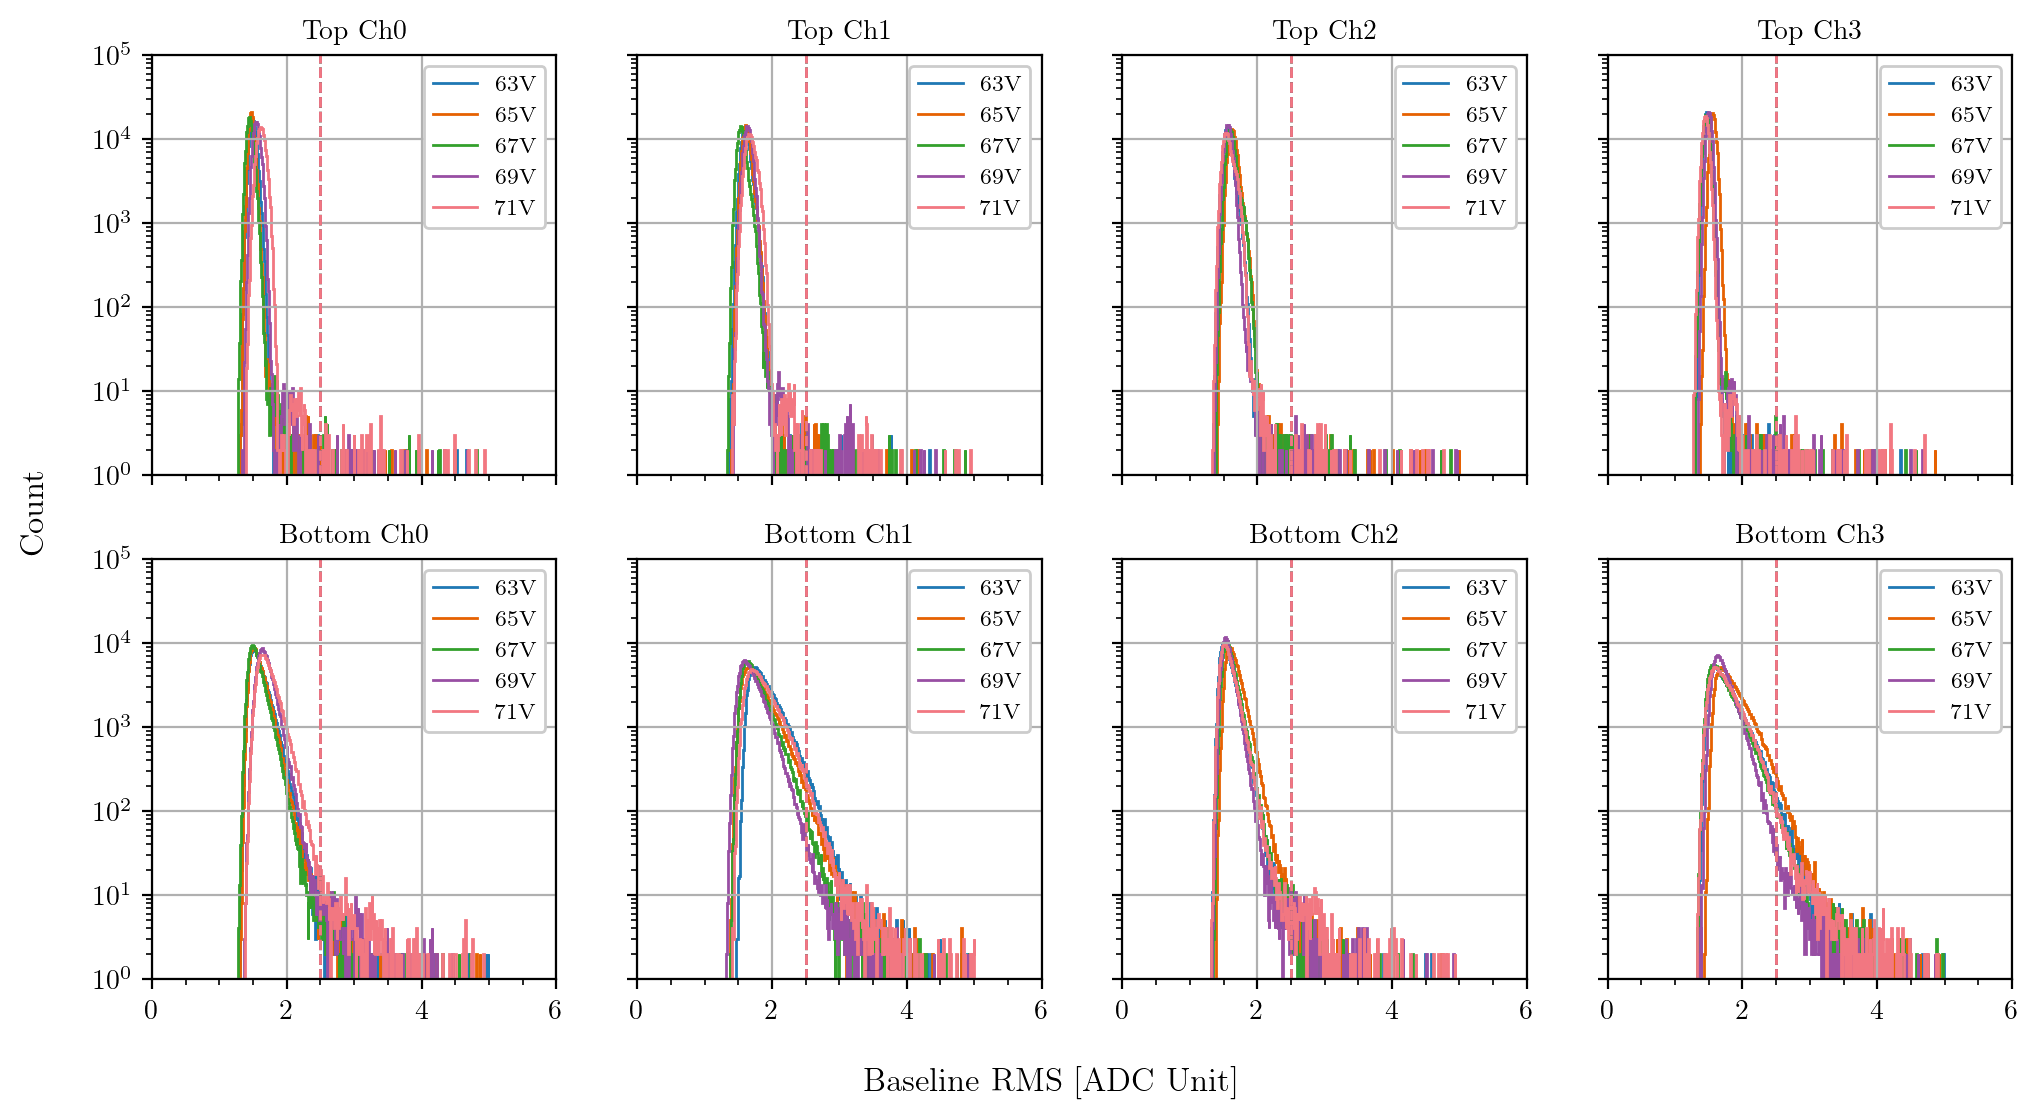

In [60]:
### Make plots for all datasets
### Baseline RMS
fig, axs = plt.subplots(2,4,sharex=True,sharey=True)
fig.set_size_inches(12,6)
for i,pos in enumerate(positions):
    for j,ch in enumerate(channels):
        for k,volt in enumerate(voltages):
            axs[i,j].stairs(baseline[pos][ch][volt]['rms_counts'], baseline[pos][ch][volt]['rms_bins'], label=f'{volt}V', color=f'C{k}')
            th = baseline[pos][ch][volt]['rms_threshold']
            axs[i,j].plot([th,th],[1,1e5],f'C{k}--',linewidth=1)
        axs[i,j].legend(loc='upper right')
        axs[i,j].set_ylim(1,1e5)
        axs[i,j].set_yscale('log')
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel('Baseline RMS [ADC Unit]',y=0.01)
fig.supylabel('Count',x=0.07)

Text(0.07, 0.5, 'Count')

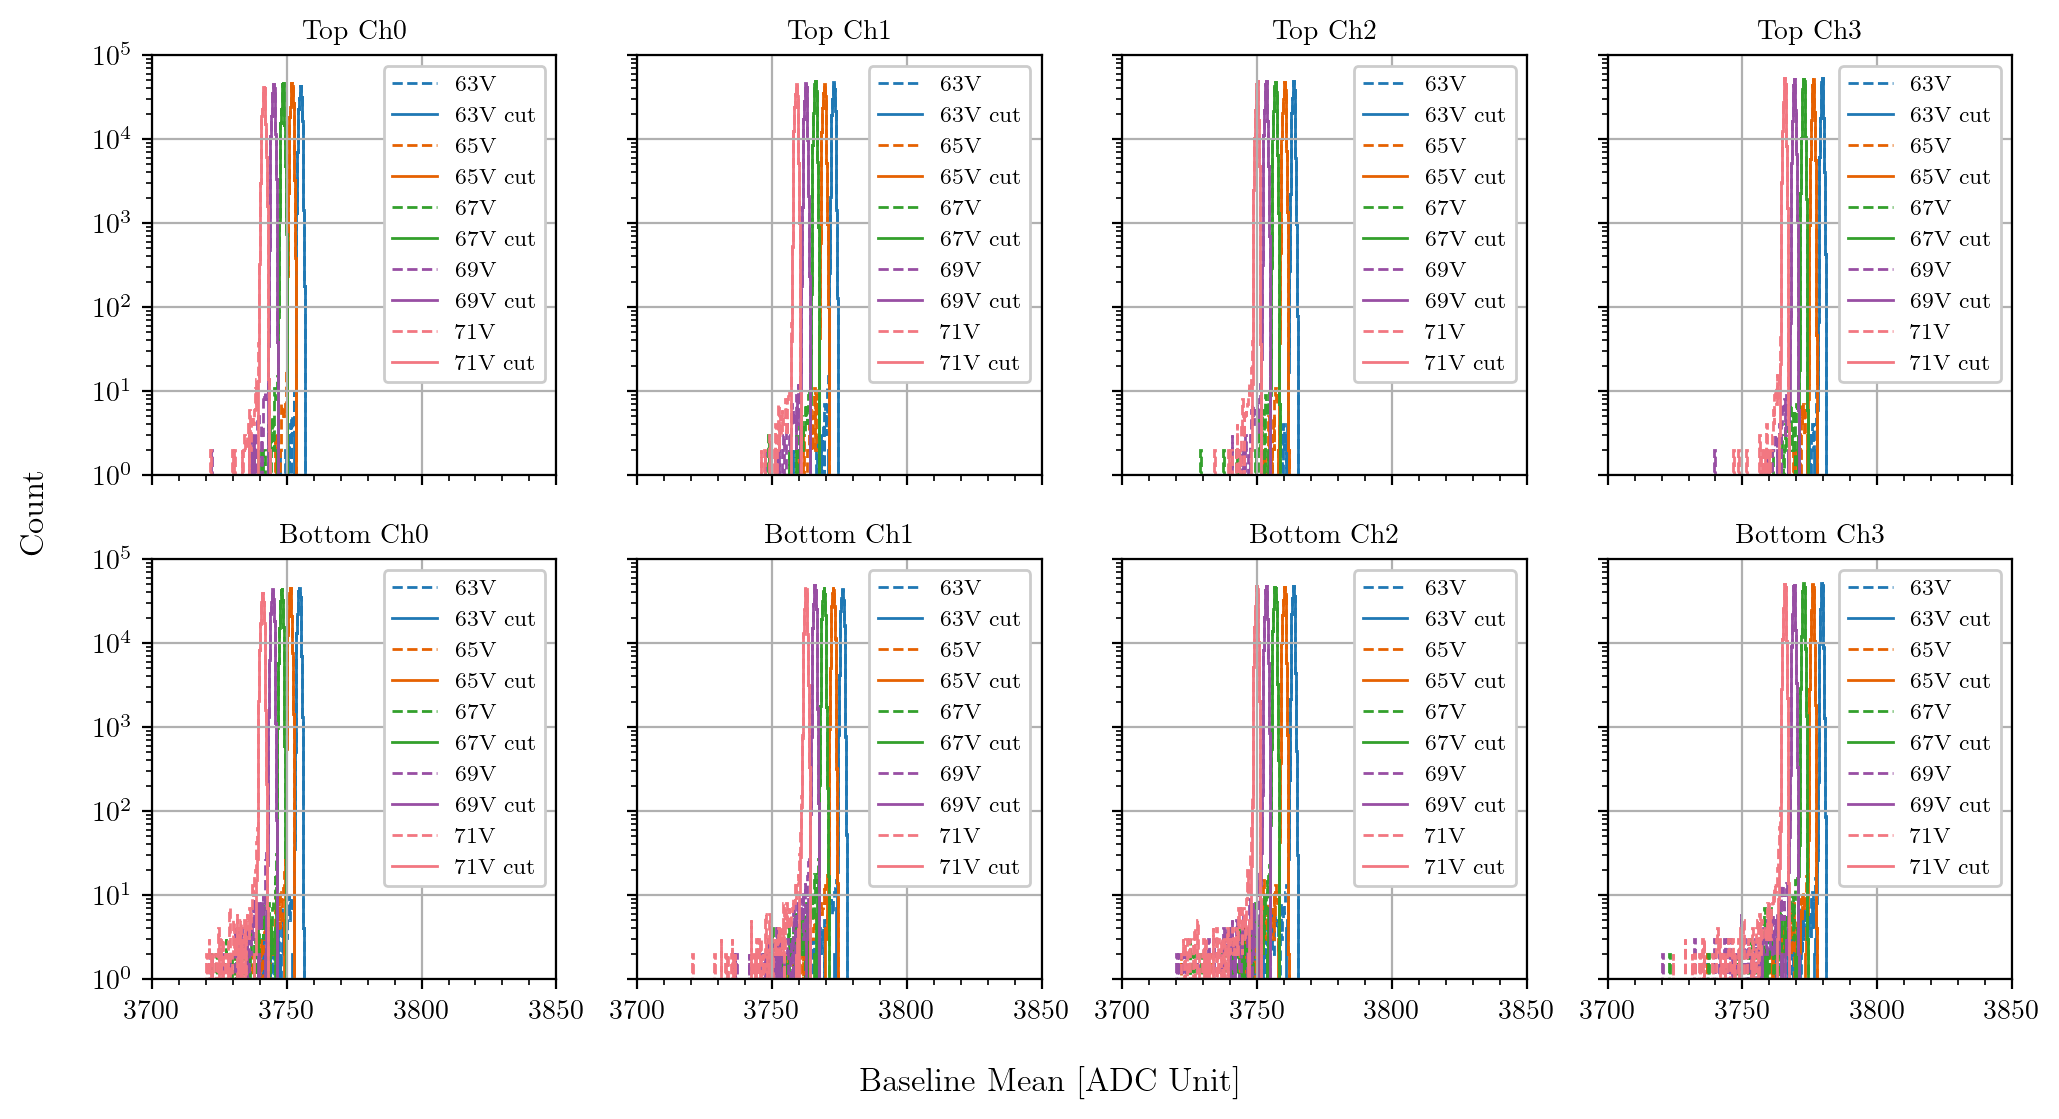

In [61]:
### Make plots for all datasets
### Baseline mean
fig, axs = plt.subplots(2,4,sharex=True,sharey=True)
fig.set_size_inches(12,6)
for i,pos in enumerate(positions):
    for j,ch in enumerate(channels):
        for k,volt in enumerate(voltages):
            axs[i,j].stairs(baseline[pos][ch][volt]['mean_counts'], baseline[pos][ch][volt]['mean_bins'], label=f'{volt}V', color=f'C{k}', linestyle='--')
            axs[i,j].stairs(baseline[pos][ch][volt]['mean_counts_cut'], baseline[pos][ch][volt]['mean_bins_cut'], label=f'{volt}V cut', color=f'C{k}')
        axs[i,j].legend(loc='upper right')
        axs[i,j].set_ylim(1,1e5)
        axs[i,j].set_yscale('log')
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel('Baseline Mean [ADC Unit]',y=0.01)
fig.supylabel('Count',x=0.07)

Plots for top ch0 63V


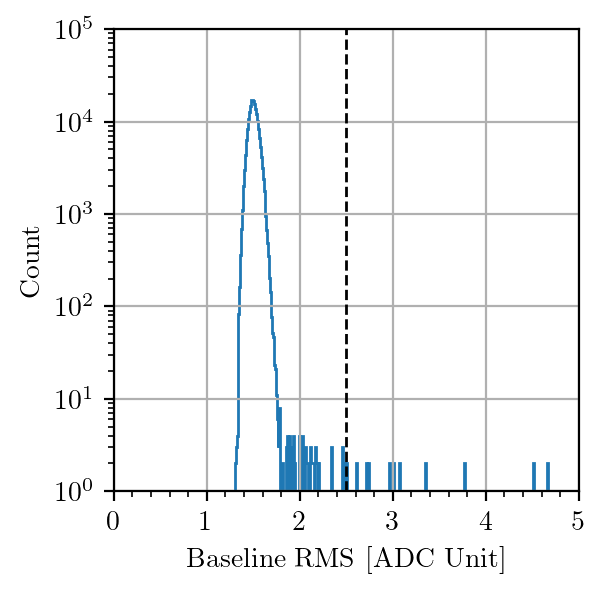

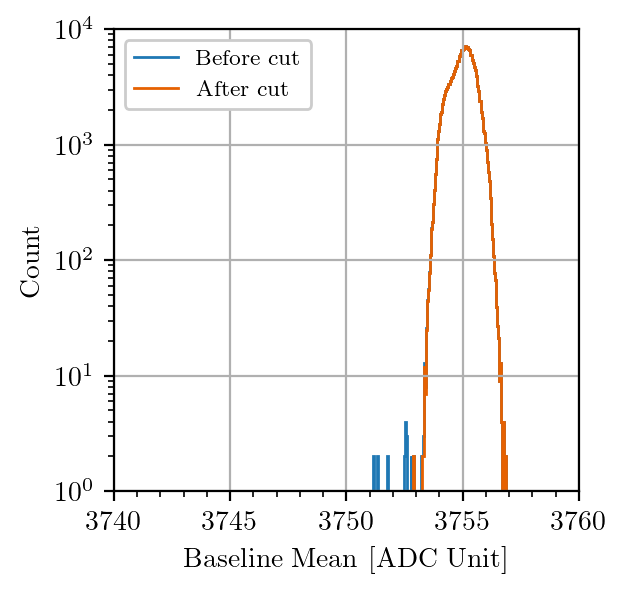

In [11]:
### Make plots for selected dataset
pos = 'top'
ch = 0
volt = 63
print(f'Plots for {pos} ch{ch} {volt}V')

# rms 
plt.figure(0,figsize=(3,3))
plt.stairs(baseline[pos][ch][volt]['rms_counts'], baseline[pos][ch][volt]['rms_bins'])
th = baseline[pos][ch][volt]['rms_threshold']
plt.plot([th,th],[1,1e5],'k--',linewidth=1)
plt.ylim(1,1e5)
plt.yscale('log')
plt.xlabel('Baseline RMS [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()

# mean
plt.figure(1,figsize=(3,3))
plt.stairs(baseline[pos][ch][volt]['mean_counts'], baseline[pos][ch][volt]['mean_bins'], label='Before cut')
plt.stairs(baseline[pos][ch][volt]['mean_counts_cut'], baseline[pos][ch][volt]['mean_bins_cut'], label='After cut')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()

## Filtered amplitude & DiCT analysis
The PE peak positions are identified with ``scipy.signal.find_peaks``.
Let $A_k$ be the peak position of the $k$-PE peak (including $k=0$). 
The boundary between $k-1$ PEs and $k$ PEs is defined as $(A_{k-1}+A_{k})/2$.
The lower boundary of the 0th PE is $A_0-0.5(A_1-A_0)$ and similarly for the upper boundary of the highest identifiable PE.
One exception is bottom ch3 which has asymmetric peaks. See code for the modified boundary criterion.
The vertical dashed lines in the finger plots represent the boundaries.

Let $P_k$ be the fraction of events within the $k$-PE boundaries. 
It can be fitted by the [compound Poisson distribution](https://ieeexplore.ieee.org/document/5402300) describing a binomial chain process, with parameter $p$ being the DiCT probability and $\mu$ being the Poisson mean of primary PEs.

In [12]:
### Initialize containers

# Amplitude histogram container
amp_histograms = {}
# Vinogradov fit & plot container
dict_fits = {}
for pos in positions:
    amp_histograms[pos] = {}
    dict_fits[pos] = {}
    for ch in channels:
        amp_histograms[pos][ch] = {}
        dict_fits[pos][ch] = {}
        for volt in voltages:
            amp_histograms[pos][ch][volt] = {}
            dict_fits[pos][ch][volt] = {}

In [13]:
### Loop over all datasets

# finger plot binning
nbins = 1500
range_min = -1e2
range_max = 1.6e3
bin_width = (range_max-range_min)/nbins
for pos in positions:
    for ch in channels:
        for volt in voltages:       
            # baseline quality cut
            df = pd.DataFrame(data[pos][ch][volt])
            df = df[df['baseline_rms']<2.5]
            # amplitude histogram
            amp_histograms[pos][ch][volt]['counts'],amp_histograms[pos][ch][volt]['bins'] = np.histogram(df['amplitude_trig'], bins=np.linspace(range_min, range_max, nbins+1))
            # find PE peaks in histogram
            p,pdict = scipy.signal.find_peaks(amp_histograms[pos][ch][volt]['counts'], prominence=70, width=10, distance=15)
            # discriminate different PE counts and calculate probability distribution P_k
            P_k = []
            npe = len(p)
            pe_cuts_in_bins = []
            for ipe in range(npe):
                if ipe==0:
                    pe_cuts_in_bins.append(int(1.5*p[0]-0.5*p[1]))
                else:
                    if pos=='bottom' and ch==3:
                        pe_cuts_in_bins.append(int(0.35*p[ipe]+0.65*p[ipe-1]))
                    elif pos=='bottom' and ch==0:
                        pe_cuts_in_bins.append(int(0.45*p[ipe]+0.55*p[ipe-1]))
                    else:
                        pe_cuts_in_bins.append(int(0.5*(p[ipe]+p[ipe-1])))
                if ipe>0:
                    P_k.append([np.sum(amp_histograms[pos][ch][volt]['counts'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]])/df.shape[0], np.sqrt(np.sum(amp_histograms[pos][ch][volt]['counts'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]]))/df.shape[0]])
            amp_histograms[pos][ch][volt]['boundaries'] = list(np.array(pe_cuts_in_bins)*bin_width+range_min)
            # Save P_k for Vinogradov fit
            dict_fits[pos][ch][volt]['y'] = np.array(P_k)[:,0]
            dict_fits[pos][ch][volt]['yerr'] = np.array(P_k)[:,1]
            dict_fits[pos][ch][volt]['x'] = np.arange(len(P_k))
            # Do Vinogradov fit
            popt,pcov = curve_fit(func.compound_poisson, dict_fits[pos][ch][volt]['x'], dict_fits[pos][ch][volt]['y'], p0=[2, 0.2], sigma=dict_fits[pos][ch][volt]['yerr'], maxfev=10000)
            # Save fit results
            dict_fits[pos][ch][volt]['par'] = popt
            dict_fits[pos][ch][volt]['cov'] = pcov
            dict_fits[pos][ch][volt]['dict'] = popt[1]
            dict_fits[pos][ch][volt]['dict_err'] = func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1])
            print(f'{pos} ch{ch} {volt}V P_dict = {dict_fits[pos][ch][volt]["dict"]:.4f} +/- {dict_fits[pos][ch][volt]["dict_err"]:.4f}')


top ch0 63V P_dict = 0.1358 +/- 0.0036
top ch0 65V P_dict = 0.1852 +/- 0.0026
top ch0 67V P_dict = 0.2373 +/- 0.0037
top ch0 69V P_dict = 0.2936 +/- 0.0059
top ch0 71V P_dict = 0.3484 +/- 0.0082
top ch1 63V P_dict = 0.1383 +/- 0.0024
top ch1 65V P_dict = 0.1902 +/- 0.0031
top ch1 67V P_dict = 0.2467 +/- 0.0025
top ch1 69V P_dict = 0.2972 +/- 0.0069
top ch1 71V P_dict = 0.3561 +/- 0.0065
top ch2 63V P_dict = 0.1260 +/- 0.0059
top ch2 65V P_dict = 0.1769 +/- 0.0014
top ch2 67V P_dict = 0.2322 +/- 0.0041
top ch2 69V P_dict = 0.2800 +/- 0.0042
top ch2 71V P_dict = 0.3383 +/- 0.0063
top ch3 63V P_dict = 0.1278 +/- 0.0022
top ch3 65V P_dict = 0.1753 +/- 0.0038
top ch3 67V P_dict = 0.2259 +/- 0.0038
top ch3 69V P_dict = 0.2840 +/- 0.0044
top ch3 71V P_dict = 0.3411 +/- 0.0088
bottom ch0 63V P_dict = 0.1201 +/- 0.0042
bottom ch0 65V P_dict = 0.1716 +/- 0.0036
bottom ch0 67V P_dict = 0.2208 +/- 0.0055
bottom ch0 69V P_dict = 0.2802 +/- 0.0077
bottom ch0 71V P_dict = 0.3351 +/- 0.0085
bottom ch1

In [14]:
### Print container keys
print('amp_histograms keys: ',list(amp_histograms[positions[0]][channels[0]][voltages[0]].keys()))
print('dict_fits keys: ',list(dict_fits[positions[0]][channels[0]][voltages[0]].keys()))

amp_histograms keys:  ['counts', 'bins', 'boundaries']
dict_fits keys:  ['y', 'yerr', 'x', 'par', 'cov', 'dict', 'dict_err']


Plots for top ch3 71V


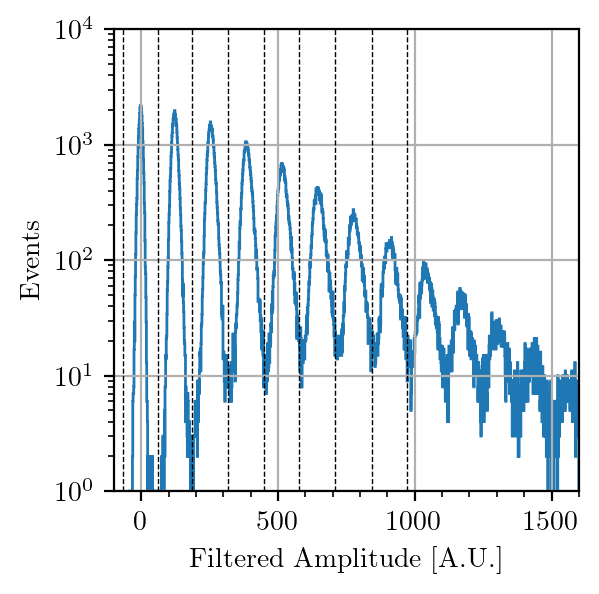

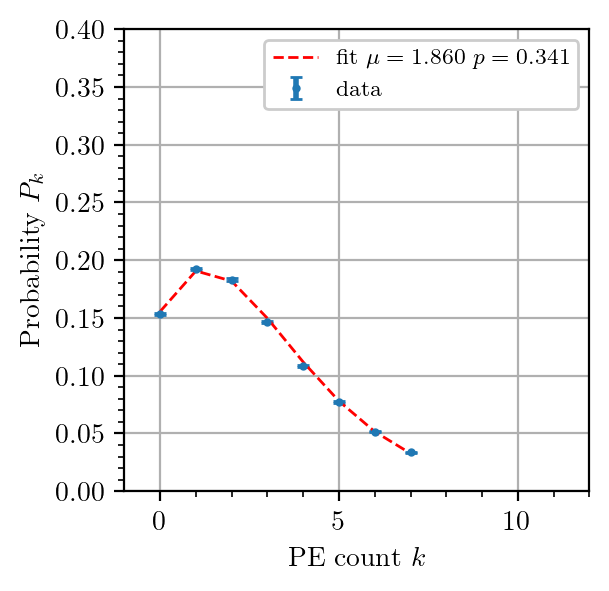

In [15]:
### Make plots for selected datasets
pos = 'top'
ch = 3
volt = 71
print(f'Plots for {pos} ch{ch} {volt}V')

# filtered amplitude histogram
plt.figure(0,figsize=(3,3))
plt.stairs(amp_histograms[pos][ch][volt]['counts'], amp_histograms[pos][ch][volt]['bins'])
for b in amp_histograms[pos][ch][volt]['boundaries']:
    plt.plot([b,b], [1,1e4], 'k--', linewidth=0.5)
plt.yscale('log')
plt.xlabel('Filtered Amplitude [A.U.]')
plt.ylabel('Events')
plt.xlim(range_min,range_max)
plt.ylim(1, 1e4)
plt.minorticks_on()
plt.grid()    

# Vinogradov fit
plt.figure(1,figsize=(3,3))
plt.errorbar(dict_fits[pos][ch][volt]['x'], dict_fits[pos][ch][volt]['y'], yerr=dict_fits[pos][ch][volt]['yerr'], fmt='o', markersize=2, label='data')
plt.plot(dict_fits[pos][ch][volt]['x'], func.compound_poisson(dict_fits[pos][ch][volt]['x'],*dict_fits[pos][ch][volt]['par']), 'r--', label=r'fit $\mu={:.3f}$ $p={:.3f}$'.format(*dict_fits[pos][ch][volt]['par']), linewidth=1)
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Probability $P_k$')
plt.ylim(0,0.4)
plt.xlim(-1,12)
plt.legend(loc='upper right')
plt.minorticks_on()
plt.grid()

# Integrated charge and afterpulsing analysis
The integral window is $5~\rm\mu s$ post-trigger and $0.5~\rm \mu s$ pre-trigger.
The integrals are grouped by the PE counts $k$ defined with the filtered amplitude (see previous cell).
The integral distribution has a Gaussian left tail but a heavier right tail due to afterpulses.
The part of the histograms near the peak is fitted by a Gaussian PDF to find the peak position, denoted by $I_{k,\rm peak}$.
$I_{k,\rm peak}$ is linear with $k$, and the slope $Q_{\rm peak}$ is the SPE gain of the SiPMs in arbitrary units.<br>

The average of the histogram, excluding overflowing bins (to reject scintillation events that have very high charge integrals), is denoted by $I_{k,\rm avg}$.
It is also linear with $k$, and the slope is denoted by $Q_{\rm avg}$.
The relative difference, $\frac{Q_{\rm avg}}{Q_{\rm peak}}-1$, is the average afterpulse charge per PE enhanced by DiCT.
Therefore, we define the afterpulse charge as $Q_{\rm AP}=(\frac{Q_{\rm avg}}{Q_{\rm peak}}-1)(1-p)$.<br>

The afterpulse *probability* is also estimated using the fraction of events under the Gaussian (i.e. the normalization of Gaussian function) out of total events.
This fraction is the probability that all $k$ cells have no afterpulse, denoted by $1-P_{\rm AP}(k)$. It should equal to $(1-P_{\rm AP})^k$, where $P_{\rm AP}$ is the afterpulse probability per PE.
$P_{\rm AP}$ extracted from the fits are consistent with $Q_{\rm AP}$, indicating that most afterpulses are a full PE.

The breakdown voltage is obtained by a linear fit to $Q_{\rm peak}$ as a function of bias $V$ using $Q_{\rm peak}=C(V-V_{\rm bd})$.
A comparison of breakdown voltage across channels is further down in the notebook.

In [16]:
### Initialize containers

# Charge histogram container
charge_histograms = {}
# Charge histogram fit & plot container
charge_fits = {}
# Gain-PE linear fit & plot container
gain_peak_fits = {}
gain_avg_fits = {}
# Afterpulsing
afterpulse = {}
afterpulse_prob = {}
ap_prob_fits = {}
# Breakdown voltage linear fit & plot container
vbd_fits = {}

for pos in positions:
    charge_histograms[pos] = {}
    charge_fits[pos] = {}
    gain_peak_fits[pos] = {}
    gain_avg_fits[pos] = {}
    afterpulse[pos] = {}
    afterpulse_prob[pos] = {}
    ap_prob_fits[pos] = {}
    vbd_fits[pos] = {}
    for ch in channels:
        charge_histograms[pos][ch] = {}
        charge_fits[pos][ch] = {}
        gain_peak_fits[pos][ch] = {}
        gain_avg_fits[pos][ch] = {}
        afterpulse[pos][ch] = {}
        afterpulse_prob[pos][ch] = {}
        ap_prob_fits[pos][ch] = {}
        vbd_fits[pos][ch] = {}
        for volt in voltages:
            charge_histograms[pos][ch][volt] = {}
            charge_fits[pos][ch][volt] = {}
            gain_peak_fits[pos][ch][volt] = {}
            gain_avg_fits[pos][ch][volt] = {}
            afterpulse[pos][ch][volt] = {}
            afterpulse_prob[pos][ch][volt] = {}
            ap_prob_fits[pos][ch][volt] = {}

In [17]:
### Loop over datasets
for pos in positions:
    for ch in channels:
        for volt in voltages:
            # finger plot binning
            nbins = 1000
            range_min = -2e3
            range_max = 6e3+(volt-63)*1e3
            bin_width = (range_max-range_min)/nbins
            # baseline quality cut
            df = pd.DataFrame(data[pos][ch][volt])
            df = df[df['baseline_rms']<2.5]
            # charge histograms grouped by amplitude
            maxpe = len(amp_histograms[pos][ch][volt]['boundaries'])-2 
            for pe in np.arange(1,maxpe+1):
                charge_histograms[pos][ch][volt][pe] = {}
                charge_fits[pos][ch][volt][pe] = {}
                afterpulse_prob[pos][ch][volt][pe] = {}
                # get amplitude boundary for each PE count
                if pe==0:
                    min_fa = amp_histograms[pos][ch][volt]['boundaries'][0]
                else:
                    min_fa = amp_histograms[pos][ch][volt]['boundaries'][pe]
                if pe==maxpe:
                    max_fa = amp_histograms[pos][ch][volt]['boundaries'][-1]
                else:
                    max_fa = amp_histograms[pos][ch][volt]['boundaries'][pe+1]
                charge_list = df[(df['amplitude_trig']<max_fa) & (df['amplitude_trig']>min_fa) & (df['integral_5p00us']<range_max) & (df['integral_5p00us']>range_min)]['integral_5p00us']
                charge_histograms[pos][ch][volt][pe]['counts'], charge_histograms[pos][ch][volt][pe]['bins'] = np.histogram(charge_list, bins=nbins, range=(range_min,range_max))
                # find appropriate fit range
                peak_bin = np.argmax(charge_histograms[pos][ch][volt][pe]['counts'])    
                fit_min = peak_bin
                while charge_histograms[pos][ch][volt][pe]['counts'][fit_min]>0.02*charge_histograms[pos][ch][volt][pe]['counts'][peak_bin]:
                    fit_min -= 1
                if charge_histograms[pos][ch][volt][pe]['counts'][fit_min]==0:
                    fit_min += 1
                charge_fits[pos][ch][volt][pe]['min_bin'] = fit_min
                fit_max = peak_bin
                while charge_histograms[pos][ch][volt][pe]['counts'][fit_max]>0.3*charge_histograms[pos][ch][volt][pe]['counts'][peak_bin]:
                    fit_max += 1
                if charge_histograms[pos][ch][volt][pe]['counts'][fit_max]==0:
                    fit_max -= 1
                charge_fits[pos][ch][volt][pe]['max_bin'] = fit_max
                # fit each histogram with Gaussian
                popt,pcov = curve_fit(  func.gauss_normalized, 
                                        0.5*(charge_histograms[pos][ch][volt][pe]['bins'][fit_min:fit_max]+charge_histograms[pos][ch][volt][pe]['bins'][fit_min+1:fit_max+1]), 
                                        charge_histograms[pos][ch][volt][pe]['counts'][fit_min:fit_max], 
                                        p0=[charge_histograms[pos][ch][volt][pe]['counts'][peak_bin]*(fit_max-fit_min)*bin_width/3,peak_bin*bin_width+range_min,(fit_max-fit_min)*bin_width/3], 
                                        sigma=np.sqrt(charge_histograms[pos][ch][volt][pe]['counts'][fit_min:fit_max]), 
                                        maxfev=100000)
                charge_fits[pos][ch][volt][pe]['par'] = popt
                charge_fits[pos][ch][volt][pe]['cov'] = pcov
                # Gain (Qpeak)
                charge_fits[pos][ch][volt][pe]['Ipeak'] = popt[1]
                charge_fits[pos][ch][volt][pe]['Ipeak_err'] = func.error_distance(df=3,sigma=1)*np.sqrt(pcov[1,1])
                # Gain+AP (Qavg)
                charge_histograms[pos][ch][volt][pe]['Iavg'] = np.mean(charge_list)
                charge_histograms[pos][ch][volt][pe]['Iavg_err'] = np.std(charge_list)/np.sqrt(len(charge_list))
                # afterpulse probability
                afterpulse_prob[pos][ch][volt][pe]['prob'] = charge_fits[pos][ch][volt][pe]['par'][0]/bin_width/len(charge_list)
                afterpulse_prob[pos][ch][volt][pe]['prob_err'] = np.sqrt(afterpulse_prob[pos][ch][volt][pe]['prob']*(1-afterpulse_prob[pos][ch][volt][pe]['prob'])/len(charge_list))
            # Qpeak fit
            gain_peak_fits[pos][ch][volt]['x'] = np.arange(maxpe)+1
            gain_peak_fits[pos][ch][volt]['y'] = np.array([charge_fits[pos][ch][volt][pe]['Ipeak'] for pe in np.arange(maxpe)+1])
            gain_peak_fits[pos][ch][volt]['yerr'] = np.array([charge_fits[pos][ch][volt][pe]['Ipeak_err'] for pe in np.arange(maxpe)+1])
            popt,pcov=curve_fit(    func.line_simple,
                                    gain_peak_fits[pos][ch][volt]['x'], 
                                    gain_peak_fits[pos][ch][volt]['y'], 
                                    sigma=gain_peak_fits[pos][ch][volt]['yerr'],
                                    p0=[500,0],
                                    maxfev=10000)
            gain_peak_fits[pos][ch][volt]['Qpeak'] = popt[0]
            gain_peak_fits[pos][ch][volt]['Qpeak_err'] = func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])
            gain_peak_fits[pos][ch][volt]['par'] = popt
            gain_peak_fits[pos][ch][volt]['cov'] = pcov
            # Qavg fit
            gain_avg_fits[pos][ch][volt]['x'] = np.arange(maxpe)+1
            gain_avg_fits[pos][ch][volt]['y'] = np.array([charge_histograms[pos][ch][volt][pe]['Iavg'] for pe in np.arange(maxpe)+1])
            gain_avg_fits[pos][ch][volt]['yerr'] = np.array([charge_histograms[pos][ch][volt][pe]['Iavg_err'] for pe in np.arange(maxpe)+1])
            popt,pcov=curve_fit(    func.line_simple,
                                    gain_avg_fits[pos][ch][volt]['x'], 
                                    gain_avg_fits[pos][ch][volt]['y'], 
                                    sigma=gain_avg_fits[pos][ch][volt]['yerr'], 
                                    p0=[500,0], 
                                    maxfev=10000)
            gain_avg_fits[pos][ch][volt]['Qavg'] = popt[0]
            gain_avg_fits[pos][ch][volt]['Qavg_err'] = func.error_distance(df=2,sigma=1)*np.sqrt(pcov[0,0])
            gain_avg_fits[pos][ch][volt]['par'] = popt
            gain_avg_fits[pos][ch][volt]['cov'] = pcov
            # Afterpulse charge
            afterpulse[pos][ch][volt]['Qap'] = gain_avg_fits[pos][ch][volt]['Qavg']/gain_peak_fits[pos][ch][volt]['Qpeak'] - 1
            afterpulse[pos][ch][volt]['Qap_err'] = (1+afterpulse[pos][ch][volt]['Qap'])*np.sqrt((gain_avg_fits[pos][ch][volt]['Qavg_err']/gain_avg_fits[pos][ch][volt]['Qavg'])**2+(gain_peak_fits[pos][ch][volt]['Qpeak_err']/gain_peak_fits[pos][ch][volt]['Qpeak'])**2)
            afterpulse[pos][ch][volt]['Qap'] *= 1-dict_fits[pos][ch][volt]['dict'] # correct for APxDiCT
            afterpulse[pos][ch][volt]['Qap_err'] *= 1-dict_fits[pos][ch][volt]['dict'] # correct for APxDiCT
            print(f'{pos} ch{ch} {volt}V Q_ap = {afterpulse[pos][ch][volt]["Qap"]:.4f} +/- {afterpulse[pos][ch][volt]["Qap_err"]:.4f}')
            # Afterpulse probability fit
            ap_prob_fits[pos][ch][volt]['x'] = np.arange(maxpe)+1
            ap_prob_fits[pos][ch][volt]['y'] = [afterpulse_prob[pos][ch][volt][pe]['prob'] for pe in np.arange(maxpe)+1]
            ap_prob_fits[pos][ch][volt]['yerr'] = [afterpulse_prob[pos][ch][volt][pe]['prob_err'] for pe in np.arange(maxpe)+1]
            popt,pcov=curve_fit(    func.power,
                                    ap_prob_fits[pos][ch][volt]['x'], 
                                    ap_prob_fits[pos][ch][volt]['y'], 
                                    sigma=ap_prob_fits[pos][ch][volt]['yerr'], 
                                    p0=[0.9], 
                                    maxfev=10000)
            ap_prob_fits[pos][ch][volt]['Pap'] = 1-popt[0]
            ap_prob_fits[pos][ch][volt]['Pap_err'] = func.error_distance(df=1,sigma=1)*np.sqrt(pcov[0,0])
            ap_prob_fits[pos][ch][volt]['par'] = popt
            ap_prob_fits[pos][ch][volt]['cov'] = pcov
            print(f'{pos} ch{ch} {volt}V P_ap = {ap_prob_fits[pos][ch][volt]["Pap"]:.4f} +/- {ap_prob_fits[pos][ch][volt]["Pap_err"]:.4f}')

top ch0 63V Q_ap = 0.0115 +/- 0.0043
top ch0 63V P_ap = 0.0087 +/- 0.0006
top ch0 65V Q_ap = 0.0154 +/- 0.0026
top ch0 65V P_ap = 0.0143 +/- 0.0005
top ch0 67V Q_ap = 0.0212 +/- 0.0021
top ch0 67V P_ap = 0.0198 +/- 0.0008
top ch0 69V Q_ap = 0.0256 +/- 0.0016
top ch0 69V P_ap = 0.0259 +/- 0.0003
top ch0 71V Q_ap = 0.0320 +/- 0.0014
top ch0 71V P_ap = 0.0292 +/- 0.0011
top ch1 63V Q_ap = 0.0082 +/- 0.0027
top ch1 63V P_ap = 0.0087 +/- 0.0003
top ch1 65V Q_ap = 0.0132 +/- 0.0022
top ch1 65V P_ap = 0.0119 +/- 0.0006
top ch1 67V Q_ap = 0.0199 +/- 0.0017
top ch1 67V P_ap = 0.0192 +/- 0.0003
top ch1 69V Q_ap = 0.0250 +/- 0.0014
top ch1 69V P_ap = 0.0239 +/- 0.0006
top ch1 71V Q_ap = 0.0296 +/- 0.0017
top ch1 71V P_ap = 0.0283 +/- 0.0008
top ch2 63V Q_ap = 0.0097 +/- 0.0011
top ch2 63V P_ap = 0.0096 +/- 0.0003
top ch2 65V Q_ap = 0.0145 +/- 0.0032
top ch2 65V P_ap = 0.0132 +/- 0.0007
top ch2 67V Q_ap = 0.0212 +/- 0.0013
top ch2 67V P_ap = 0.0194 +/- 0.0007
top ch2 69V Q_ap = 0.0266 +/- 0.0025
t

In [18]:
### Fitting for breakdown voltage
for pos in positions:
    for ch in channels:
        vbd_fits[pos][ch]['x'] = voltages
        vbd_fits[pos][ch]['y'] = [gain_peak_fits[pos][ch][volt]['Qpeak'] for volt in voltages]
        vbd_fits[pos][ch]['yerr'] = [gain_peak_fits[pos][ch][volt]['Qpeak_err'] for volt in voltages]
        popt,pcov = curve_fit(  func.line, 
                                vbd_fits[pos][ch]['x'],
                                vbd_fits[pos][ch]['y'],
                                sigma=vbd_fits[pos][ch]['yerr'],
                                p0=[100, 55],
                                maxfev=10000)
        vbd_fits[pos][ch]['vbd'] = popt[1]
        vbd_fits[pos][ch]['vbd_err'] = func.error_distance(df=2,sigma=1)*np.sqrt(pcov[1,1])
        vbd_fits[pos][ch]['par'] = popt
        vbd_fits[pos][ch]['cov'] = pcov
        print(f'{pos} ch{ch} Vbd = {vbd_fits[pos][ch]["vbd"]:.2f} +/- {vbd_fits[pos][ch]["vbd_err"]:.2f} V')

top ch0 Vbd = 53.77 +/- 0.51 V
top ch1 Vbd = 53.35 +/- 0.20 V
top ch2 Vbd = 53.77 +/- 0.24 V
top ch3 Vbd = 53.15 +/- 0.77 V
bottom ch0 Vbd = 54.33 +/- 0.27 V
bottom ch1 Vbd = 53.39 +/- 0.74 V
bottom ch2 Vbd = 53.91 +/- 0.26 V
bottom ch3 Vbd = 53.81 +/- 0.40 V


In [19]:
### Print container keys
print('charge_histograms keys: ',list(charge_histograms[positions[0]][channels[0]][voltages[0]][1].keys()))
print('charge_fits keys: ',list(charge_fits[positions[0]][channels[0]][voltages[0]][1].keys()))
print('gain_peak_fits keys: ',list(gain_peak_fits[positions[0]][channels[0]][voltages[0]].keys()))
print('gain_avg_fits keys: ',list(gain_avg_fits[positions[0]][channels[0]][voltages[0]].keys()))
print('afterpulse keys: ',list(afterpulse[positions[0]][channels[0]][voltages[0]].keys()))
print('vbd_fits keys: ',list(vbd_fits[positions[0]][channels[0]].keys()))

charge_histograms keys:  ['counts', 'bins', 'Iavg', 'Iavg_err']
charge_fits keys:  ['min_bin', 'max_bin', 'par', 'cov', 'Ipeak', 'Ipeak_err']
gain_peak_fits keys:  ['x', 'y', 'yerr', 'Qpeak', 'Qpeak_err', 'par', 'cov']
gain_avg_fits keys:  ['x', 'y', 'yerr', 'Qavg', 'Qavg_err', 'par', 'cov']
afterpulse keys:  ['Qap', 'Qap_err']
vbd_fits keys:  ['x', 'y', 'yerr', 'vbd', 'vbd_err', 'par', 'cov']


Plots for top ch3 71V


Text(0, 0.5, '$1-P_{\\rm AP}(k)$')

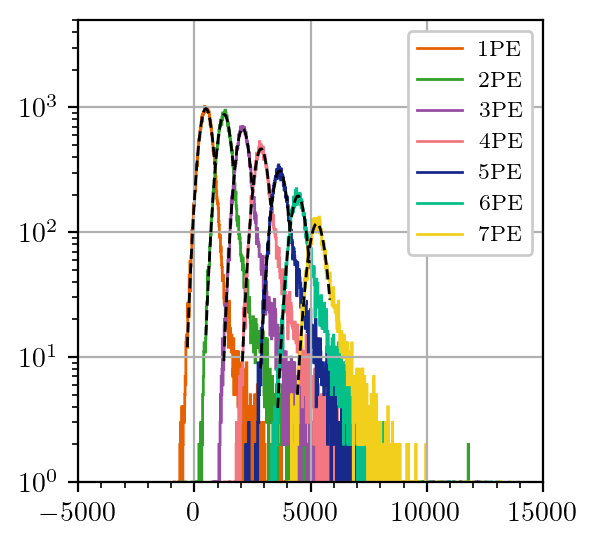

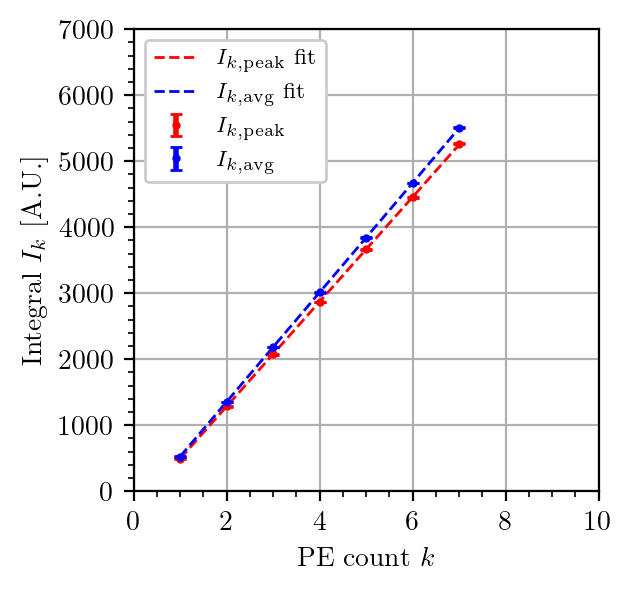

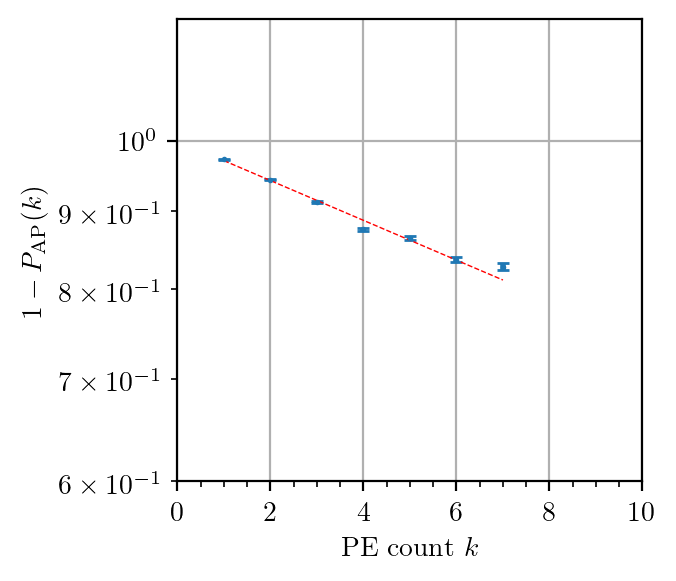

In [20]:
### Make plots for selected datasets
pos = 'top'
ch = 3
volt = 71
print(f'Plots for {pos} ch{ch} {volt}V')

# charge histograms
plt.figure(0,figsize=(3,3))
for pe in charge_histograms[pos][ch][volt].keys():
    plt.stairs(charge_histograms[pos][ch][volt][pe]['counts'], charge_histograms[pos][ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
    fit_min = charge_fits[pos][ch][volt][pe]['min_bin']
    fit_max = charge_fits[pos][ch][volt][pe]['max_bin']
    plt.plot(charge_histograms[pos][ch][volt][pe]['bins'][fit_min:fit_max],func.gauss_normalized(charge_histograms[pos][ch][volt][pe]['bins'][fit_min:fit_max],*charge_fits[pos][ch][volt][pe]['par']), f'k--', linewidth=1)
plt.legend(loc='upper right')
plt.ylim(1,5e3)
plt.yscale('log')
plt.minorticks_on()
plt.grid()

# charge-pe linear fits
plt.figure(1,figsize=(3,3))
plt.errorbar(gain_peak_fits[pos][ch][volt]['x'],gain_peak_fits[pos][ch][volt]['y'], yerr=gain_peak_fits[pos][ch][volt]['yerr'], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
plt.plot(gain_peak_fits[pos][ch][volt]['x'], func.line_simple(gain_peak_fits[pos][ch][volt]['x'], *gain_peak_fits[pos][ch][volt]['par']), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
plt.errorbar(gain_avg_fits[pos][ch][volt]['x'],gain_avg_fits[pos][ch][volt]['y'], yerr=gain_avg_fits[pos][ch][volt]['yerr'], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
plt.plot(gain_avg_fits[pos][ch][volt]['x'], func.line_simple(gain_avg_fits[pos][ch][volt]['x'], *gain_avg_fits[pos][ch][volt]['par']), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
plt.legend()
plt.xlabel(r'PE count $k$')
plt.ylabel(r'Integral $I_k$ [A.U.]')
plt.xlim(0,10)
plt.ylim(0,7e3)
plt.legend()
plt.grid()
plt.minorticks_on()

# afterpulse probability
plt.figure(2,figsize=(3,3))
plt.errorbar(   ap_prob_fits[pos][ch][volt]['x'], 
                ap_prob_fits[pos][ch][volt]['y'], 
                yerr=ap_prob_fits[pos][ch][volt]['yerr'], 
                fmt='o', 
                markersize=1)
plt.plot(   ap_prob_fits[pos][ch][volt]['x'], 
            func.power(ap_prob_fits[pos][ch][volt]['x'],*ap_prob_fits[pos][ch][volt]['par']),
            'r--', 
            linewidth=0.5)
plt.xlim(0, 10)
plt.ylim(0.6,1.2)
plt.yscale('log')
plt.minorticks_on()
plt.grid()
plt.xlabel(r'PE count $k$')
plt.ylabel(r'$1-P_{\rm AP}(k)$')

# Summary

In [21]:
### Initialize container
summary = {'vbd':{},'dict':{},'ap_charge':{},'ap_prob':{},'gain':{}}
for pos in positions:
    summary['dict'][pos] = {}
    summary['ap_charge'][pos] = {}
    summary['ap_prob'][pos] = {}
    summary['gain'][pos] = {}
    for ch in channels:
        summary['dict'][pos][ch] = {}
        summary['ap_charge'][pos][ch] = {}
        summary['ap_prob'][pos][ch] = {}
        summary['gain'][pos][ch] = {}

In [22]:
### Fill container

# Vbd-channel
summary['vbd']['x'] = []
summary['vbd']['xlabel'] = []
summary['vbd']['y'] = []
summary['vbd']['yerr'] = []

for pos in positions:
    for ch in channels:
        # DiCT-Vbias    
        summary['dict'][pos][ch]['x'] = voltages
        summary['dict'][pos][ch]['y'] = [dict_fits[pos][ch][volt]['dict'] for volt in voltages]
        summary['dict'][pos][ch]['yerr'] = [dict_fits[pos][ch][volt]['dict_err'] for volt in voltages]
        # Qap-Vbias
        summary['ap_charge'][pos][ch]['x'] = voltages
        summary['ap_charge'][pos][ch]['y'] = [afterpulse[pos][ch][volt]['Qap'] for volt in voltages]
        summary['ap_charge'][pos][ch]['yerr'] = [afterpulse[pos][ch][volt]['Qap_err'] for volt in voltages]
        # Pap-Vbias
        summary['ap_prob'][pos][ch]['x'] = voltages
        summary['ap_prob'][pos][ch]['y'] = [ap_prob_fits[pos][ch][volt]['Pap'] for volt in voltages]
        summary['ap_prob'][pos][ch]['yerr'] = [ap_prob_fits[pos][ch][volt]['Pap_err'] for volt in voltages]
        # gain-Vbias
        summary['gain'][pos][ch]['x'] = voltages
        summary['gain'][pos][ch]['y'] = [gain_peak_fits[pos][ch][volt]['Qpeak'] for volt in voltages]
        summary['gain'][pos][ch]['yerr'] = [gain_peak_fits[pos][ch][volt]['Qpeak_err'] for volt in voltages]
        summary['gain'][pos][ch]['xfit'] = sorted(voltages + [vbd_fits[pos][ch]['vbd']])
        summary['gain'][pos][ch]['yfit'] = func.line(np.array(summary['gain'][pos][ch]['xfit']),*vbd_fits[pos][ch]['par'])
        # Vbd-channel
        summary['vbd']['x'].append(len(summary['vbd']['x']))
        summary['vbd']['xlabel'].append(f"{pos[0]}{ch}")
        summary['vbd']['y'].append(vbd_fits[pos][ch]['vbd'])
        summary['vbd']['yerr'].append(vbd_fits[pos][ch]['vbd_err'])

In [23]:
# Print container keys
print('summary keys: ',list(summary.keys()))

summary keys:  ['vbd', 'dict', 'ap_charge', 'ap_prob', 'gain']


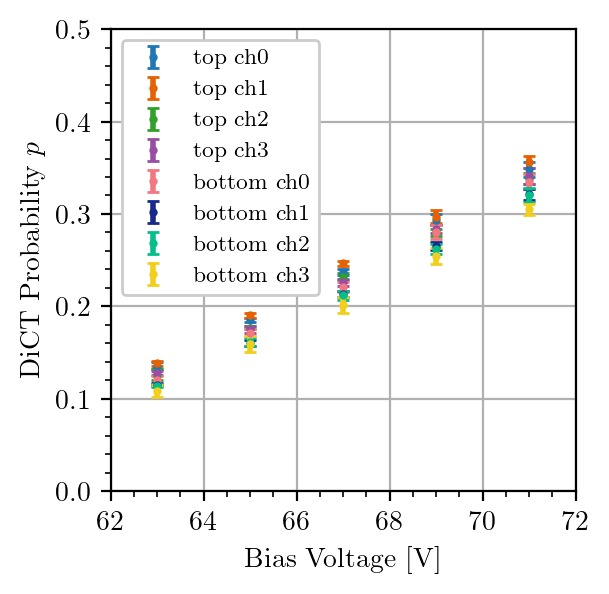

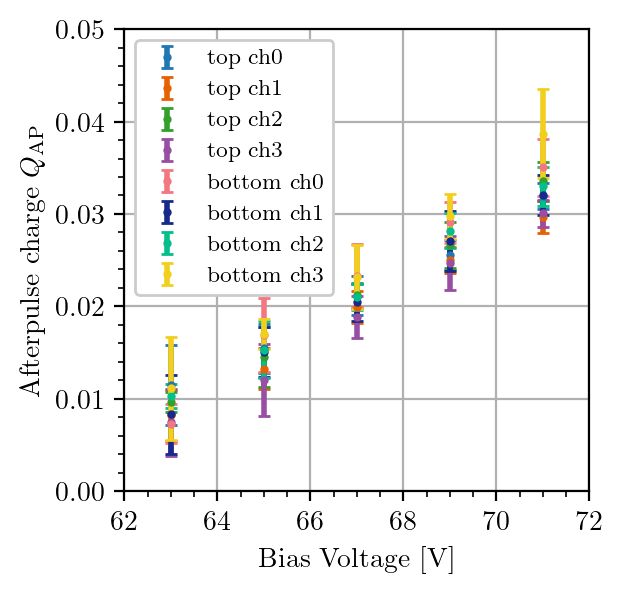

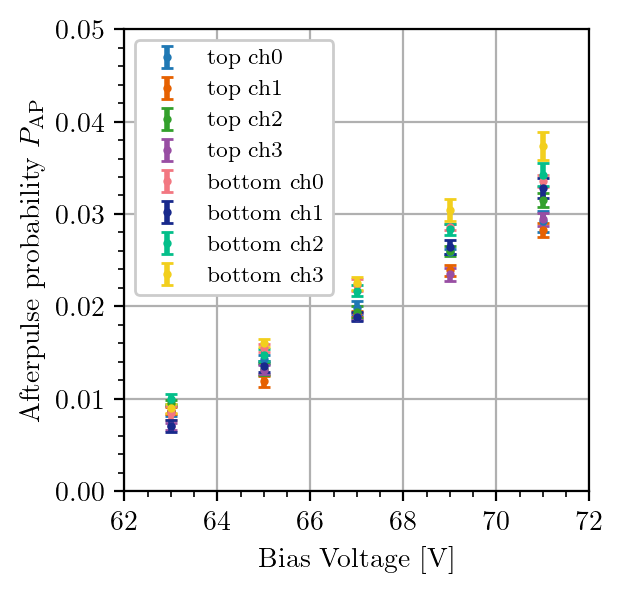

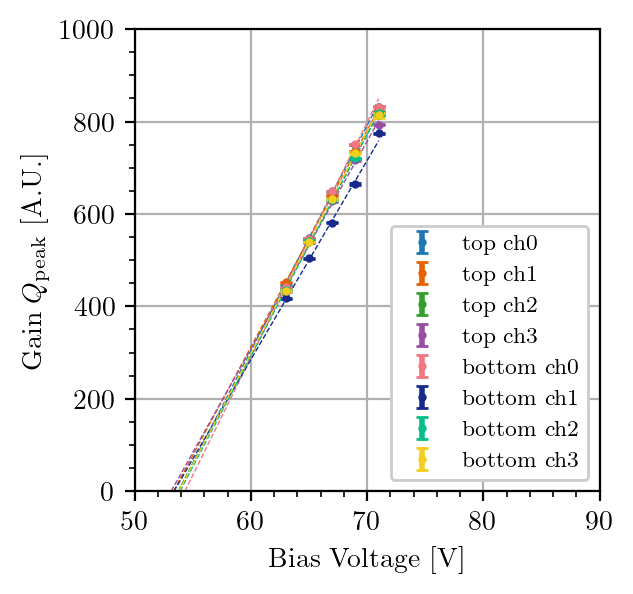

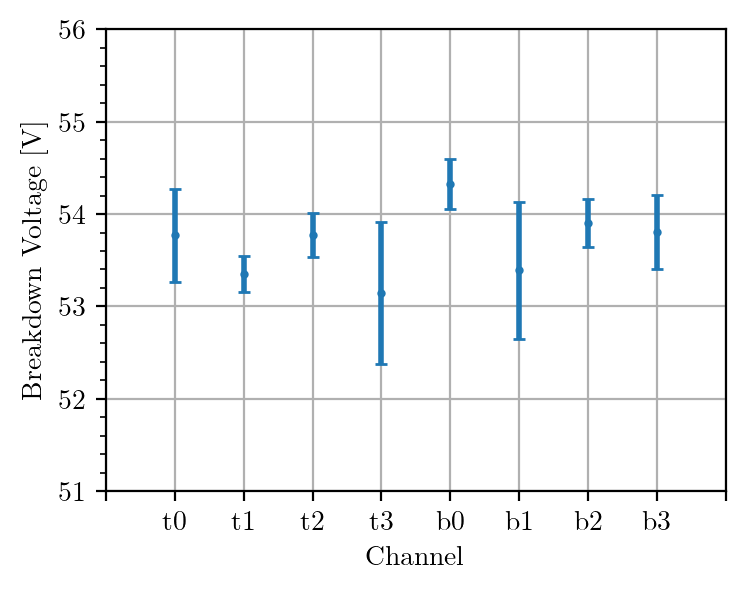

Breakdown voltage per SiPM = 26.87+/-0.05(stat) V
RMS variation = 0.19V


In [24]:
### Make summary plots

# DiCT-Vbias
plt.figure(0,figsize=(3,3))
for pos in positions:
    for ch in channels:
        plt.errorbar(   summary['dict'][pos][ch]['x'], 
                        summary['dict'][pos][ch]['y'],
                        yerr=summary['dict'][pos][ch]['yerr'],
                        label=f'{pos} ch{ch}',
                        fmt='C{}o'.format(ch+4*int(pos!='top')),
                        markersize=2)
plt.legend()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'DiCT Probability $p$')
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0, 0.5)

# Qap-Vbias
plt.figure(1,figsize=(3,3))
for pos in positions:
    for ch in channels:
        plt.errorbar(   summary['ap_charge'][pos][ch]['x'], 
                        summary['ap_charge'][pos][ch]['y'],
                        yerr=summary['ap_charge'][pos][ch]['yerr'],
                        label=f'{pos} ch{ch}',
                        fmt='C{}o'.format(ch+4*int(pos!='top')),
                        markersize=2)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Afterpulse charge $Q_{\rm AP}$')
plt.xlim(62,72)
plt.ylim(0, 0.05)

# Pap-Vbias
plt.figure(2,figsize=(3,3))
for pos in positions:
    for ch in channels:
        plt.errorbar(   summary['ap_prob'][pos][ch]['x'], 
                        summary['ap_prob'][pos][ch]['y'],
                        yerr=summary['ap_prob'][pos][ch]['yerr'],
                        label=f'{pos} ch{ch}',
                        fmt='C{}o'.format(ch+4*int(pos!='top')),
                        markersize=2)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Afterpulse probability $P_{\rm AP}$')
plt.xlim(62,72)
plt.ylim(0, 0.05)

# Gain-Vbias
plt.figure(3,figsize=(3,3))
for pos in positions:
    for ch in channels:
        plt.errorbar(   summary['gain'][pos][ch]['x'], 
                        summary['gain'][pos][ch]['y'],
                        yerr=summary['gain'][pos][ch]['yerr'],
                        label=f'{pos} ch{ch}',
                        fmt='C{}o'.format(ch+4*int(pos!='top')),
                        markersize=2)
        plt.plot(   summary['gain'][pos][ch]['xfit'], 
                    summary['gain'][pos][ch]['yfit'],
                    'C{}--'.format(ch+4*int(pos!='top')),
                    linewidth=0.5 )
plt.legend(loc='lower right')
plt.xlabel('Bias Voltage [V]')
plt.ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
plt.grid()
plt.minorticks_on()
plt.xlim(50,90)
plt.ylim(0, 1.0e3)

# Vbd-channel
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax = plt.subplots()
plt.errorbar(summary['vbd']['x'], summary['vbd']['y'], yerr=summary['vbd']['yerr'], fmt='o', markersize=2)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage [V]')
ax.xaxis.set(ticks=summary['vbd']['x'],ticklabels=summary['vbd']['xlabel'])
plt.xlim(-1,8)
plt.ylim(51,56)
plt.grid()
plt.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.show()

# Analyze Vbd distribution
vbd_array = np.array(summary['vbd']['y'])
vbd_err_array = np.array(summary['vbd']['yerr'])
vbd_avg = np.average(vbd_array, weights=1/vbd_err_array**2)/2
vbd_stat = np.sum(vbd_err_array**(-2))**(-0.5)/2
print('Breakdown voltage per SiPM = {:.2f}+/-{:.2f}(stat) V'.format(vbd_avg,vbd_stat))
vbd_rms = np.std(vbd_array,ddof=1)/2
print('RMS variation = {:.2f}V'.format(vbd_rms))

## Write to csv file

In [25]:
import csv
for volt in voltages:
    with open('data/calibration/calibration_1122_{}V.csv'.format(volt), 'w') as f:
        w = csv.writer(f)
        w.writerow(['CH', 'A1min', 'A1max', 'p', 'p_err', 'Qavg', 'Qavg_err', 'Qpeak', 'Qpeak_err', 'Qap', 'Qap_err'])
        for pos in positions:
            for ch in channels:
                row = [f'{pos[0].upper()}{ch}']
                row += [str(amp_histograms[pos][ch][volt]['boundaries'][1]), str(amp_histograms[pos][ch][volt]['boundaries'][2])]
                row += [str(dict_fits[pos][ch][volt]['dict']), str(dict_fits[pos][ch][volt]['dict_err'])]
                row += [str(gain_avg_fits[pos][ch][volt]['Qavg']), str(gain_avg_fits[pos][ch][volt]['Qavg_err'])]
                row += [str(gain_peak_fits[pos][ch][volt]['Qpeak']), str(gain_peak_fits[pos][ch][volt]['Qpeak_err'])]
                row += [str(afterpulse[pos][ch][volt]['Qap']), str(afterpulse[pos][ch][volt]['Qap_err'])]
                w.writerow(row)

## Calculate $\frac{1+p}{PDE}$ versus over-voltage

Welcome to JupyROOT 6.26/06


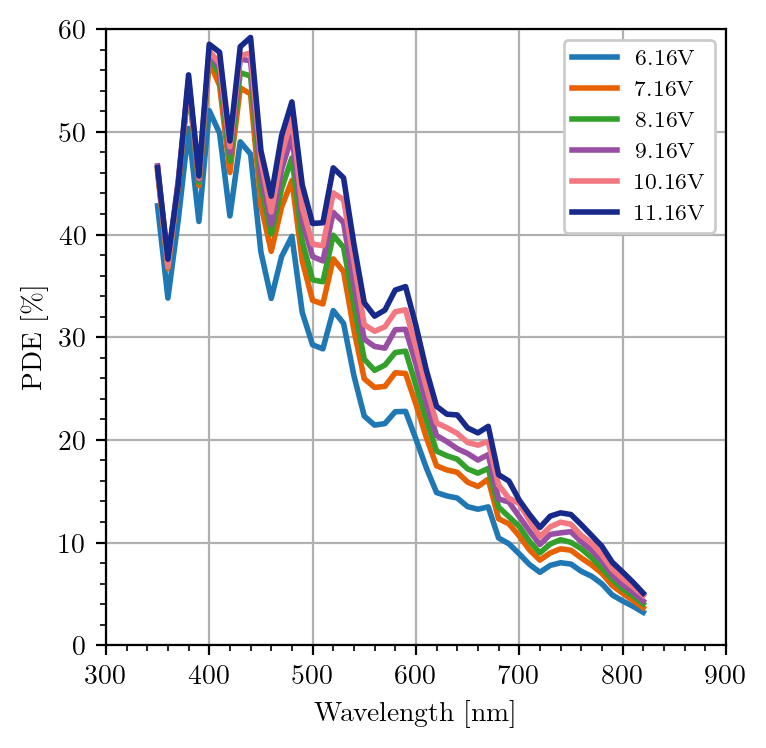

In [26]:
import ROOT
from scipy.interpolate import interp1d

### Read PDE data
plt.figure(0,figsize=(4,4))
vov = [6.16,7.16,8.16,9.16,10.16,11.16]
pde_curves = []
for v in vov:
    pde_curves.append({'wavelength':[],'pde':[]})
    with open('data/sipm/PDE_{}V.csv'.format(v)) as f:
        r = csv.reader(f)
        header = next(r)
        for row in r:
            if(len(row)==0):
                break
            pde_curves[-1]['wavelength'].append(float(row[0]))
            pde_curves[-1]['pde'].append(float(row[1]))
    plt.plot(np.array(pde_curves[-1]['wavelength']), np.array(pde_curves[-1]['pde']), label='{:.2f}V'.format(v))
plt.legend(loc='upper right')
plt.minorticks_on()
plt.grid()
plt.xlabel('Wavelength [nm]')
plt.ylabel('PDE [\%]')

pde_volt = []
for i in range(len(vov)):
    pde_volt.append(interp1d(np.array(pde_curves[i]['wavelength']), np.array(pde_curves[i]['pde'])))

pde420nm = interp1d( np.array(vov), np.array( [pde_volt[i](420)/100 for i in range(len(vov))] ) )

Text(0, 0.5, 'ENF')

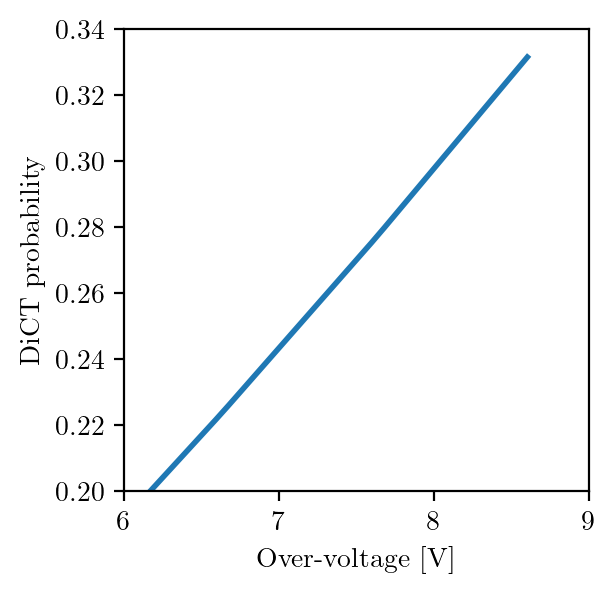

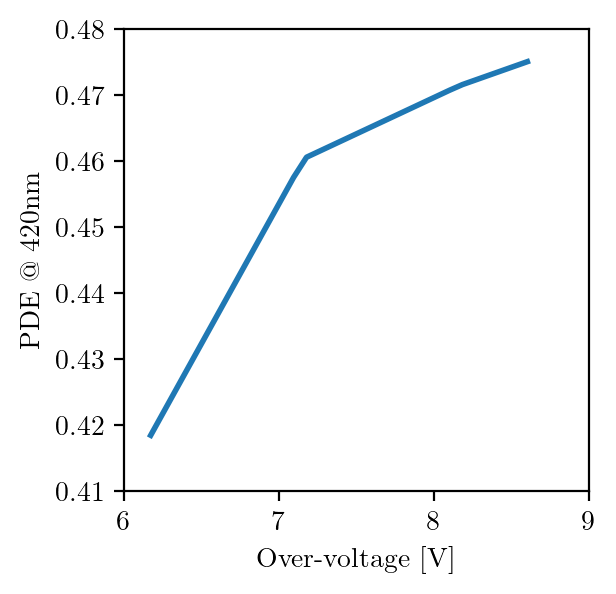

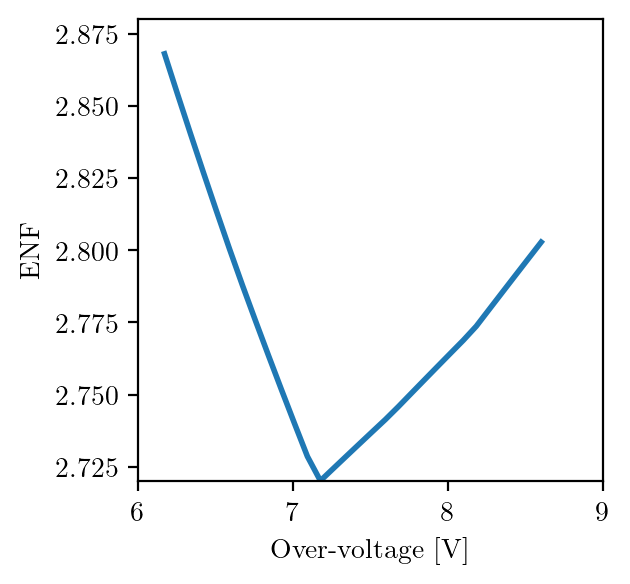

In [27]:
### Get average DiCT $p$ and then compute ENF

dict_avg = [np.mean([[dict_fits[pos][ch][volt]['dict'] for ch in channels] for pos in positions]) for volt in voltages]
ov = np.array(voltages)/2 - vbd_avg
dict_ov = interp1d(ov, dict_avg)

ov_plot = np.linspace(6.17, 8.6, 30)
plt.figure(0,figsize=(3,3))
plt.plot(ov_plot,dict_ov(ov_plot))
plt.xlabel('Over-voltage [V]')
plt.ylabel('DiCT probability')
plt.figure(1,figsize=(3,3))
plt.plot(ov_plot, pde420nm(ov_plot))
plt.xlabel('Over-voltage [V]')
plt.ylabel('PDE @ 420nm')
plt.figure(2,figsize=(3,3))
plt.plot(ov_plot, (1+dict_ov(ov_plot))/pde420nm(ov_plot))
plt.xlabel('Over-voltage [V]')
plt.ylabel('ENF')